In [1]:
import numpy as np
import pandas as pd

#Keras
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# sklearn utilities
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import robust_scale

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
county_area = pd.read_csv('county_area.csv')
county_area = county_area.drop(["Areaname"], axis=1)
county_area = county_area.rename(columns={"STCOU": "fips"})

In [3]:
county_mask_use = pd.read_csv('mask_use.csv')
county_mask_use = county_mask_use.rename(columns={"COUNTYFP": "fips"})

In [4]:
county_cases = pd.read_csv('county_cases.csv')
county_cases = county_cases.drop(["county","state"], axis=1)

In [5]:
county_pop = pd.read_csv('county_pop.csv', encoding='latin-1')
county_pop = county_pop.rename(columns={"COUNTY": "fips"})

In [6]:
def new_normal(table):
    normal = robust_scale(table)
    return normal

In [7]:
df = county_pop.merge(county_mask_use, how='left', on="fips")
df = df.merge(county_area, how="left", on="fips")
df['POP_DEN'] = df['POPESTIMATE2019'] / df['AREA']
df['POP_DENxALWAYS'] = df['POP_DEN'] * df['ALWAYS']
df['POP_DENxFREQUENTLY'] =df['POP_DEN'] * df['FREQUENTLY']
df['POP_DENxSOMETIMES'] = df['POP_DEN'] * df['SOMETIMES']
df['POP_DENxRARELY'] = df['POP_DEN'] * df['RARELY']
df['POP_DENxNEVER'] = df['POP_DEN'] * df['NEVER']
df['POPxALWAYS'] = df['POPESTIMATE2019'] * df['ALWAYS']
df['POPxFREQUENTLY'] =df['POPESTIMATE2019'] * df['FREQUENTLY']
df['POPxSOMETIMES'] = df['POPESTIMATE2019'] * df['SOMETIMES']
df['POPxRARELY'] = df['POPESTIMATE2019'] * df['RARELY']
df['POPxNEVER'] = df['POPESTIMATE2019'] * df['NEVER']

In [8]:
df = df.merge(county_cases, how="left", on="fips")
df.insert(0, 'Ones', 1)
column_titles = ["POPESTIMATE2019","NEVER","RARELY","SOMETIMES","FREQUENTLY","ALWAYS","AREA","POP_DEN","POP_DENxALWAYS","POP_DENxFREQUENTLY","POP_DENxSOMETIMES","POP_DENxRARELY","POP_DENxNEVER",'POPxALWAYS','POPxFREQUENTLY','POPxSOMETIMES','POPxRARELY','POPxNEVER']
new_df = df.reindex(columns=column_titles)
normal_all = new_normal(new_df)
normal_df = pd.DataFrame(normal_all)
normal_df.columns = column_titles
normal_df['fips'] = df['fips']
normal_df = normal_df.merge(county_cases, how="left", on="fips")
column_titles = ["fips","cases","deaths","POPESTIMATE2019","NEVER","RARELY","SOMETIMES","FREQUENTLY","ALWAYS","AREA","POP_DEN","POP_DENxALWAYS","POP_DENxFREQUENTLY","POP_DENxSOMETIMES","POP_DENxRARELY","POP_DENxNEVER",'POPxALWAYS','POPxFREQUENTLY','POPxSOMETIMES','POPxRARELY','POPxNEVER']

#column_titles = ["cases","deaths","POPESTIMATE2019","NEVER","RARELY","SOMETIMES","FREQUENTLY","ALWAYS"]

normal_df = normal_df.reindex(columns=column_titles)


In [9]:
df.describe()

,Ones,fips,POPESTIMATE2019,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,AREA,POP_DEN,...,POP_DENxSOMETIMES,POP_DENxRARELY,POP_DENxNEVER,POPxALWAYS,POPxFREQUENTLY,POPxSOMETIMES,POPxRARELY,POPxNEVER,cases,deaths
count,3128.0,3128.000000,3.128000e+03,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,...,3128.000000,3128.000000,3128.000000,3.128000e+03,3.128000e+03,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000
mean,1.0,30399.191176,1.018080e+05,0.080054,0.083164,0.121587,0.207722,0.507468,1201.750959,189.197356,...,15.715272,8.329482,8.152766,6.622361e+04,1.812400e+04,8461.713067,4620.537216,4373.188840,2649.581202,63.391304
std,0.0,15160.277769,3.266086e+05,0.058583,0.055450,0.057947,0.063086,0.151746,3950.341979,641.317191,...,41.922789,18.970393,22.226932,2.460537e+05,4.918925e+04,20005.210436,8627.136800,8834.387137,10055.894415,263.073556
min,1.0,1001.000000,2.720000e+02,0.000000,0.000000,0.001000,0.029000,0.115000,1.830000,0.032894,...,0.002195,0.000000,0.000000,1.079840e+02,3.959200e+01,14.954000,0.000000,0.000000,1.000000,0.000000
25%,1.0,18178.500000,1.093325e+04,0.034000,0.040000,0.079000,0.164000,0.393000,446.662500,16.001897,...,1.717453,0.990430,0.795094,4.763204e+03,2.167079e+03,1239.599500,744.545250,650.115250,209.750000,2.000000
50%,1.0,29174.000000,2.572600e+04,0.068000,0.073000,0.116000,0.204000,0.497000,651.450000,42.069497,...,4.688885,2.950060,2.757230,1.243253e+04,5.144329e+03,2852.185000,1864.873000,1712.970000,602.500000,10.000000
75%,1.0,45083.500000,6.764400e+04,0.113000,0.115000,0.157000,0.247000,0.612250,984.825000,110.631768,...,12.933940,7.757497,7.437118,3.664095e+04,1.393814e+04,7859.272000,4791.787500,4512.892000,1692.250000,34.000000
max,1.0,56045.000000,1.003911e+07,0.432000,0.384000,0.422000,0.549000,0.889000,158995.950000,11102.214746,...,831.578975,436.592771,678.108197,7.890738e+06,1.315123e+06,491916.243000,130508.391000,210821.247000,299760.000000,6993.000000


In [10]:
index = df[(df['cases'] >= 25000)|(df['cases'] <= 0)].index
df.drop(index, inplace=True)
normal_df.drop(index, inplace=True)
df['cases'].describe()

count     3080.000000
mean      1783.756818
std       3423.313676
min          1.000000
25%        207.000000
50%        585.000000
75%       1587.750000
max      24770.000000
Name: cases, dtype: float64

In [11]:
def split(X, Y, size):
    return train_test_split(X, Y, test_size=size)

In [12]:
# Split Data
normal_svm_df = normal_df.drop(['cases','fips'], axis=1)
cols = df.shape[1]

X = np.array(normal_svm_df) # iloc slicing function 
y = np.array(df['cases'])

In [13]:
#X = X.reshape(X.shape[0], X.shape[1], 1)
print(X.shape)
print(y.shape)

(3080, 19)
(3080,)


In [14]:
xtrain, xtest, ytrain, ytest=train_test_split(X, y, test_size=0.2) 

In [15]:
# Scale both training and testing input data

xtrain = preprocessing.scale(xtrain, with_mean=False)
xtest = preprocessing.scale(xtest, with_mean=False)

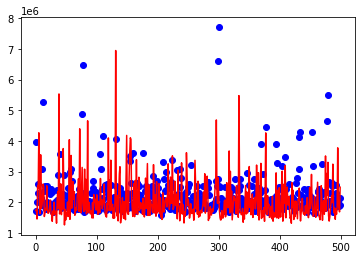

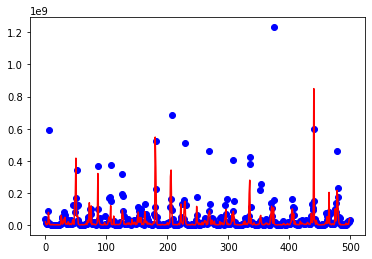

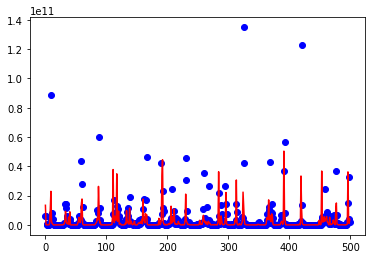

In [16]:
# Plots the results of a learning rate of 100, 1000, and 10000 respectively, with all other parameters constant

LR = [1,10,100,1000,10000]

for i in LR:
    #Defines linear regression model and its structure
    model = Sequential()
    model.add(Dense(1, input_shape=(19,)))
    
    #Compiles model
    model.compile(Adam(lr=i), 'mean_squared_error')
    
    #Fits model
    history = model.fit(xtrain, ytrain, epochs = 500, validation_split = 0.1,verbose = 0)
    history_dict=history.history
    
    #Plots model's training cost/loss and model's validation split cost/loss
    loss_values = history_dict['loss']
    val_loss_values=history_dict['val_loss']
    plt.figure()
    plt.plot(loss_values,'bo',label='training loss')
    plt.plot(val_loss_values,'r',label='val training loss')

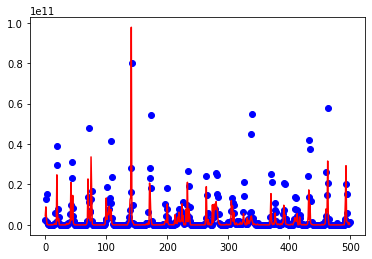

In [17]:
# Runs and plots the performance of a model with the same parameters from before (and a learning rate of 10000), 
# but now with an activation function (Relu)

#Defines linear regression model and its structure
model = Sequential()
model.add(Dense(1, input_shape=(19,)))

#Compiles model
model.compile(Adam(lr=10000), 'mean_squared_error')

#Fits model
history = model.fit(xtrain, ytrain, epochs = 500, validation_split = 0.1,verbose = 0)
history_dict=history.history

#Plots model's training cost/loss and model's validation split cost/loss
loss_values = history_dict['loss']
val_loss_values=history_dict['val_loss']
plt.figure()
plt.plot(loss_values,'bo',label='training loss')
plt.plot(val_loss_values,'r',label='val training loss')
plt.show()

In [18]:
# Runs model (the one with the activation function, although this doesn't really matter as they perform the same) 
# with its current weights on the training and testing data
ytrain_pred = model.predict(xtrain)
ytest_pred = model.predict(xtest)

# Calculates and prints r2 score of training and testing data
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(ytrain, ytrain_pred)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(ytest, ytest_pred)))

The R2 score on the Train set is:	-79.037
The R2 score on the Test set is:	-94.122


In [ ]:
# Defines "deep" model and its structure
model = Sequential()
model.add(Dense(13, input_shape=(19,), activation='relu'))
model.add(Dense(13, activation='relu'))
model.add(Dense(13, activation='relu'))
model.add(Dense(13, activation='relu'))
model.add(Dense(13, activation='relu'))
model.add(Dense(1,))
model.compile(Adam(lr=0.003), 'mean_squared_error')

# Runs model for 2000 iterations and assigns this to 'history'
history = model.fit(xtrain, ytrain, epochs = 2000, validation_split = 0.2, verbose = 0)

# Plots 'history'
history_dict=history.history
loss_values = history_dict['loss']
val_loss_values=history_dict['val_loss']
plt.plot(loss_values,'bo',label='training loss')
plt.plot(val_loss_values,'r',label='training loss val')

In [ ]:
# Defines "deep" model and its structure

model = Sequential()
model.add(Dense(13, input_shape=(19,), activation='relu'))
model.add(Dense(13, activation='relu'))
model.add(Dense(13, activation='relu'))
model.add(Dense(13, activation='relu'))
model.add(Dense(13, activation='relu'))
model.add(Dense(1,))
model.compile(Adam(lr=0.0005), 'mean_squared_error', metrics=['mae'])

# Pass several parameters to 'EarlyStopping' function and assigns it to 'earlystopper'
earlystopper = EarlyStopping(monitor='loss', min_delta=0, patience=15, verbose=1, mode='auto')

# Fits model over 2000 iterations with 'earlystopper' callback, and assigns it to history
history = model.fit(xtrain, ytrain, epochs = 3000, validation_split = 0.2, shuffle = True, verbose = 0, 
                    callbacks = [earlystopper])
print(model.evaluate(xtrain, ytrain))

# Plots 'history'
history_dict=history.history
loss_values = history_dict['loss']
val_loss_values=history_dict['val_loss']
plt.plot(loss_values,'bo',label='training loss')
plt.plot(val_loss_values,'r',label='training loss val')

# Runs model with its current weights on the training and testing data
ytrain_pred = model.predict(xtrain)
ytest_pred = model.predict(xtest)

# Calculates and prints r2 score of training and testing data
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(ytrain, ytrain_pred)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(ytest, ytest_pred)))

In [ ]:
plt.plot(ytrain, ytrain_pred,'*r')
plt.plot(ytest, ytest_pred, '+g')
plt.figure()
#for i in range(0,140):
#    plt.plot(i/100,i/100,'*b')